In [1]:
import dynamo as dyn
import pandas as pd
import numpy as np
import scipy
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

adata_hsc_raw = dyn.read("./hsc_all_combined_all_layers.h5ad")


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Read and set HSC metadata

In [3]:
adata_labeling = adata_hsc_raw
# TODO: csv results from leiden
labeling_obs_metadata = pd.read_csv("adata_labeling_all_combined_processed_final.csv", index_col=0)
labeling_obs_metadata.head()


,batch,time,cell_type,nGenes,nCounts,pMito,pass_basic_filter,new_Size_Factor,initial_new_cell_size,total_Size_Factor,...,pca_ddhodge_potential,umap_ori_ddhodge_div,umap_ori_ddhodge_potential,curl_umap_ori,divergence_umap_ori,control_point_umap_ori,inlier_prob_umap_ori,obs_vf_angle_umap_ori,n_counts,mt_frac
barcode,,,,,,,,,,,,,,,,,,,,,
CCACAAGCGTGC-JL12_0,JL12_0,3,Mon,1196,1944.0,0.114198,True,1.039024,852.0,1.227772,...,0.507833,-16.341991,1.792488,-0.046206,0.112111,False,0.999549,0.176351,3466.0,0.073572
CCATCCTGTGGA-JL12_0,JL12_0,3,Meg,1172,1706.0,0.067995,True,0.506098,415.0,1.002834,...,4.700147,41.514399,3.392540,0.098062,-0.273977,False,0.860345,0.354914,2831.0,0.048746
CCCTCGGCCGCA-JL12_0,JL12_0,3,Mon,663,915.0,0.044809,True,0.507317,416.0,0.718030,...,0.659788,-10.063857,1.593789,-0.017185,0.040728,False,0.999324,-0.352141,2027.0,0.024667
CCGCCCACCATG-JL12_0,JL12_0,3,Mon,2349,4739.0,0.138637,True,3.087805,2532.0,3.222813,...,0.609316,-15.608460,1.580450,0.110991,0.144292,False,0.999277,-0.449798,9098.0,0.086942
CCGCTGTGTAAG-JL12_0,JL12_0,3,MPP,1365,2140.0,0.077103,True,1.018293,835.0,1.231669,...,0.526728,-4.605920,1.269363,-0.040901,0.104698,False,0.999717,0.006409,3477.0,0.057521


In [4]:
adata_labeling.shape, labeling_obs_metadata.shape


((2019, 26193), (1947, 36))

In [5]:
obs_names = set(adata_labeling.obs_names).intersection(labeling_obs_metadata.index)
obs_names = list(obs_names)
# adata_labeling = adata_labeling[obs_names, :]


In [6]:
adata_labeling.obs["cell_type"] = np.nan
adata_labeling.obs["cell_type"][obs_names] = list(labeling_obs_metadata.loc[obs_names, "cell_type"])


In [7]:
adata_labeling.obs["cell_type"].unique()


array(['Mon', 'Meg', 'MPP', 'Ery', 'Bas', 'GMP', nan, 'HSC', 'Neu'],
      dtype=object)

In [8]:
adata_labeling.obs["cell_type"] = adata_labeling.obs["cell_type"].map(
    {
        "GMP": "GMP-like",
        "MPP": "MEP-like",
        "Mon": "Mon",
        "Meg": "Meg",
        "Ery": "Ery",
        "Bas": "Bas",
        "HSC": "HSC",
        "Neu": "Neu",
    }
)

adata_labeling.obs["cell_type"].value_counts()


MEP-like    457
Mon         423
HSC         309
Ery         234
Bas         177
GMP-like    161
Meg         154
Neu          32
Name: cell_type, dtype: int64

In [10]:
adata_labeling_processed = dyn.sample_data.hematopoiesis()

|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad


In [12]:
adata_labeling_processed.obs.cell_type.value_counts()

MEP-like    457
Mon         423
HSC         309
Ery         234
Bas         177
GMP-like    161
Meg         154
Neu          32
Name: cell_type, dtype: int64

In [15]:
adata_labeling

AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch', 'cell_type'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced'

In [16]:
adata_labeling = adata_labeling[adata_labeling_processed.obs_names]
adata_labeling.obsm["X_umap"] = adata_labeling_processed[adata_labeling.obs_names].obsm["X_umap"]
adata_labeling.write_h5ad("hsc_raw_with_metadata.h5ad")

## Leiden cluster to celltype

In [9]:
adata_labeling.obs.time.unique()

AttributeError: 'DataFrame' object has no attribute 'time'

|-----> accessing adj_matrix_key=X_umap_connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> X_umap_connectivities to obsp in AnnData Object.
|-----> <insert> X_umap_distances to obsp in AnnData Object.
|-----> <insert> X_umap_neighbors to uns in AnnData Object.
|-----> <insert> X_umap_neighbors.indices to uns in AnnData Object.
|-----> <insert> X_umap_neighbors.params to uns in AnnData Object.
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> Detecting community with initial_membership input from caller
|-----> [Community clustering with leiden] in progress: 100.0000%
|-----> [Community clustering with leiden] finished [2.3561s]
|-----> accessing adj_matrix_key=X_pca_connectivities built from args for clustering...
|-----> Start computing neighbor graph...
|-----> metho

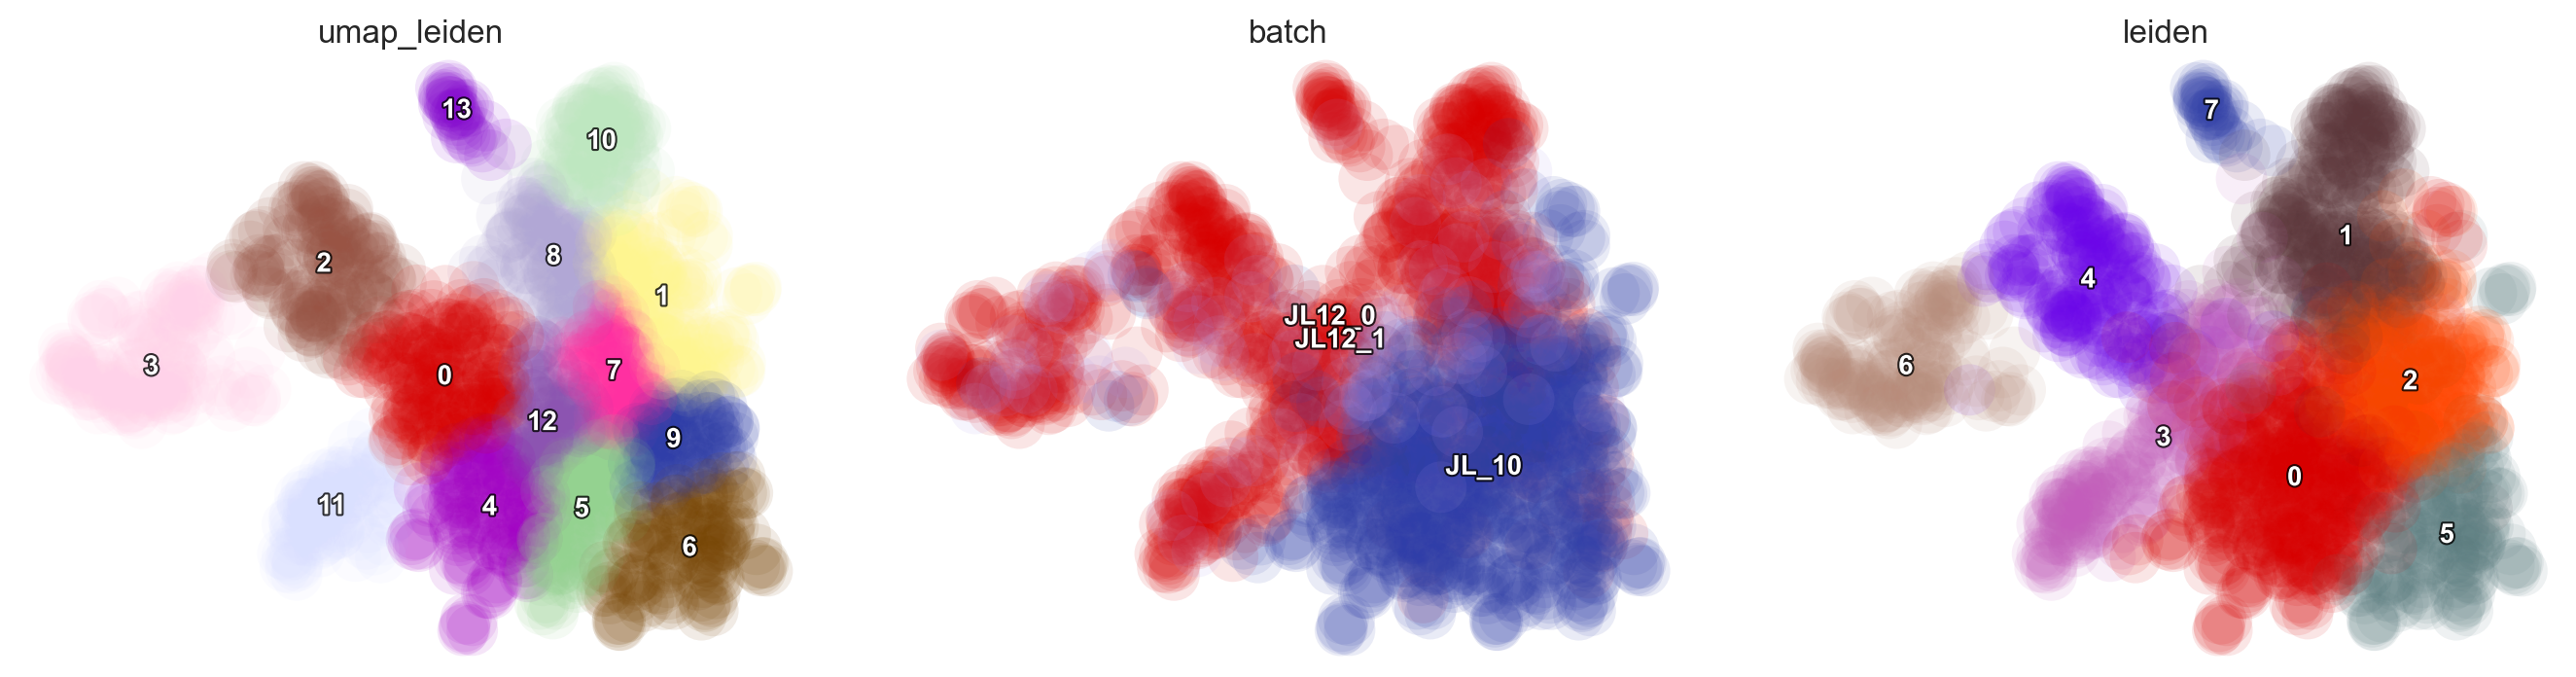

In [ ]:
dynamo_revision_genes = ["LYZ", "PLEK", "MPO", "LMO4", "HBB"]

adata_labeling.obsm["X_pca"] = adata_processed.obsm["X_pca"].copy()
dyn.tl.leiden(adata_labeling, obsm_key="X_umap", result_key="umap_leiden")
dyn.tl.leiden(adata_labeling, obsm_key="X_pca")
dyn.pl.scatters(
    adata_labeling,
    color=["umap_leiden", "batch", "leiden"] + list(adata_hsc_raw.var_names.intersection(dynamo_revision_genes)),
)


In [ ]:
dyn.tl.neighbors(adata_labeling, basis="umap");


|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


|-----> accessing adj_matrix_key=X_umap_connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [3.7680s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering umap_leiden by stack threshold when stacking color because it is not a numeric type
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type
|-----------> skip filtering umap_louvain by stack threshold when stacking color because it is not a numeric type


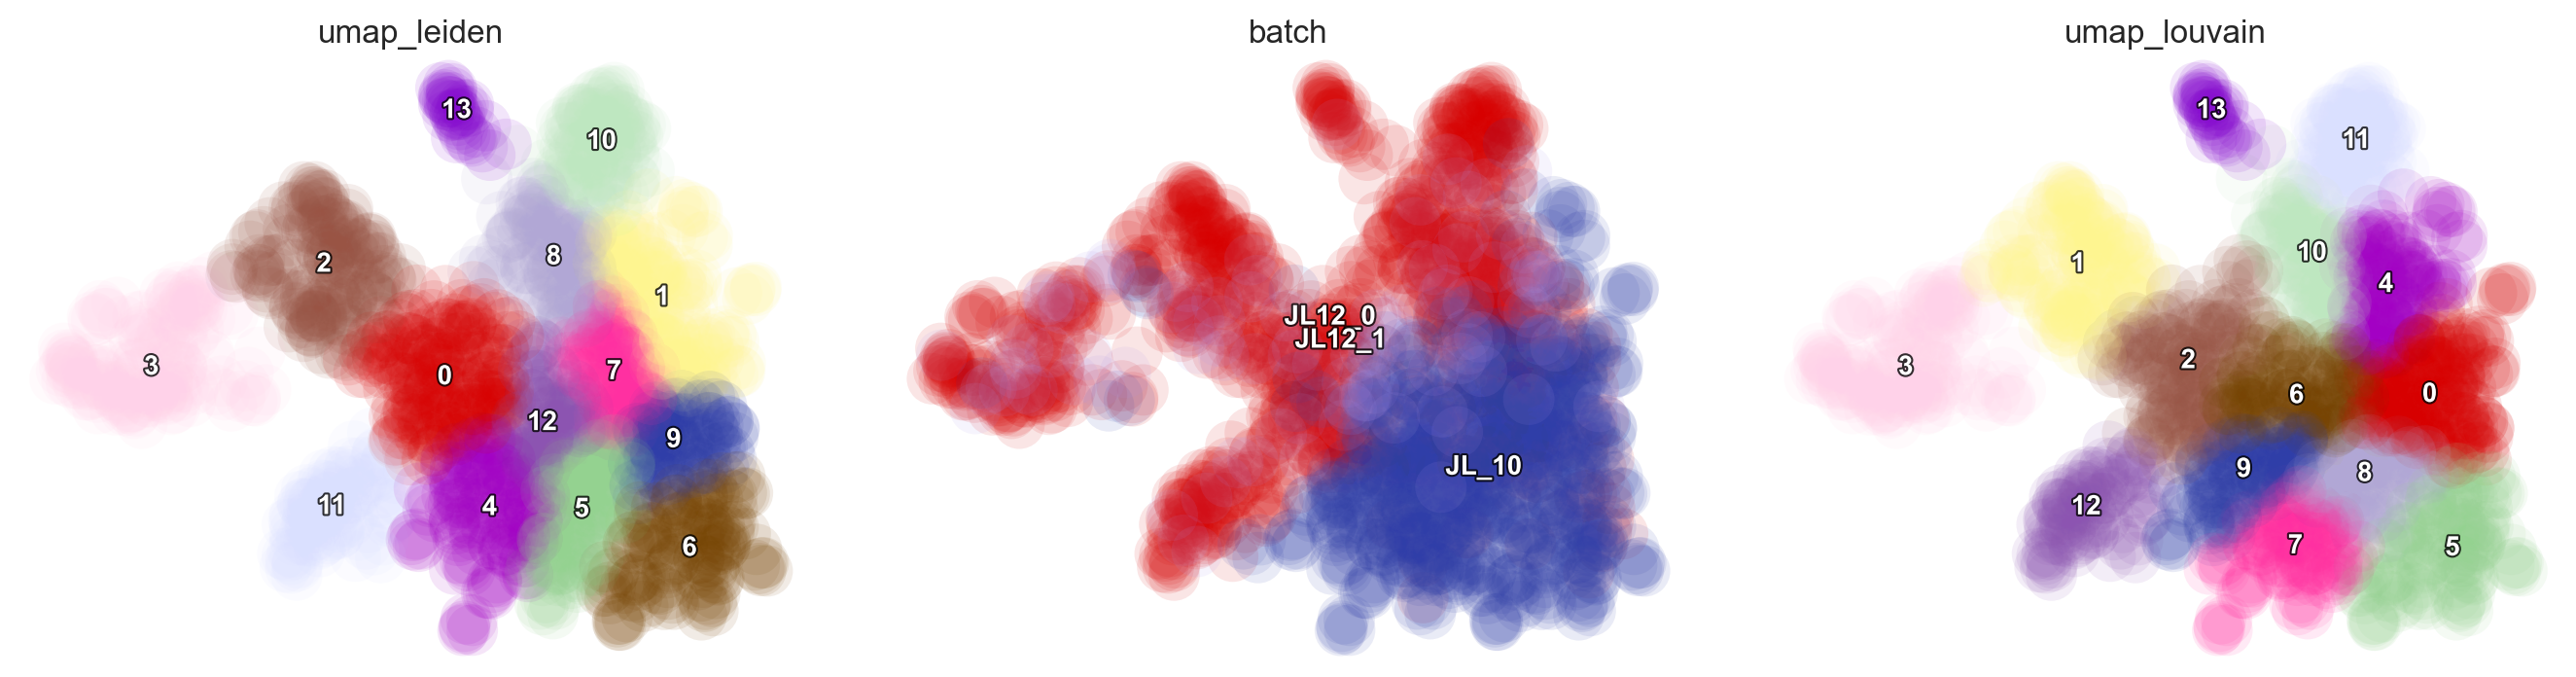

In [ ]:
dyn.tl.louvain(adata_labeling, obsm_key="X_umap", result_key="umap_louvain", adj_matrix_key="X_umap_connectivities")
dyn.pl.scatters(
    adata_labeling,
    color=["umap_leiden", "batch", "umap_louvain"] + list(adata_hsc_raw.var_names.intersection(dynamo_revision_genes)),
)


|-----> using adj_matrix passed from arg for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to networkx object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [3.1355s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type
|-----------> skip filtering umap_louvain by stack threshold when stacking color because it is not a numeric type


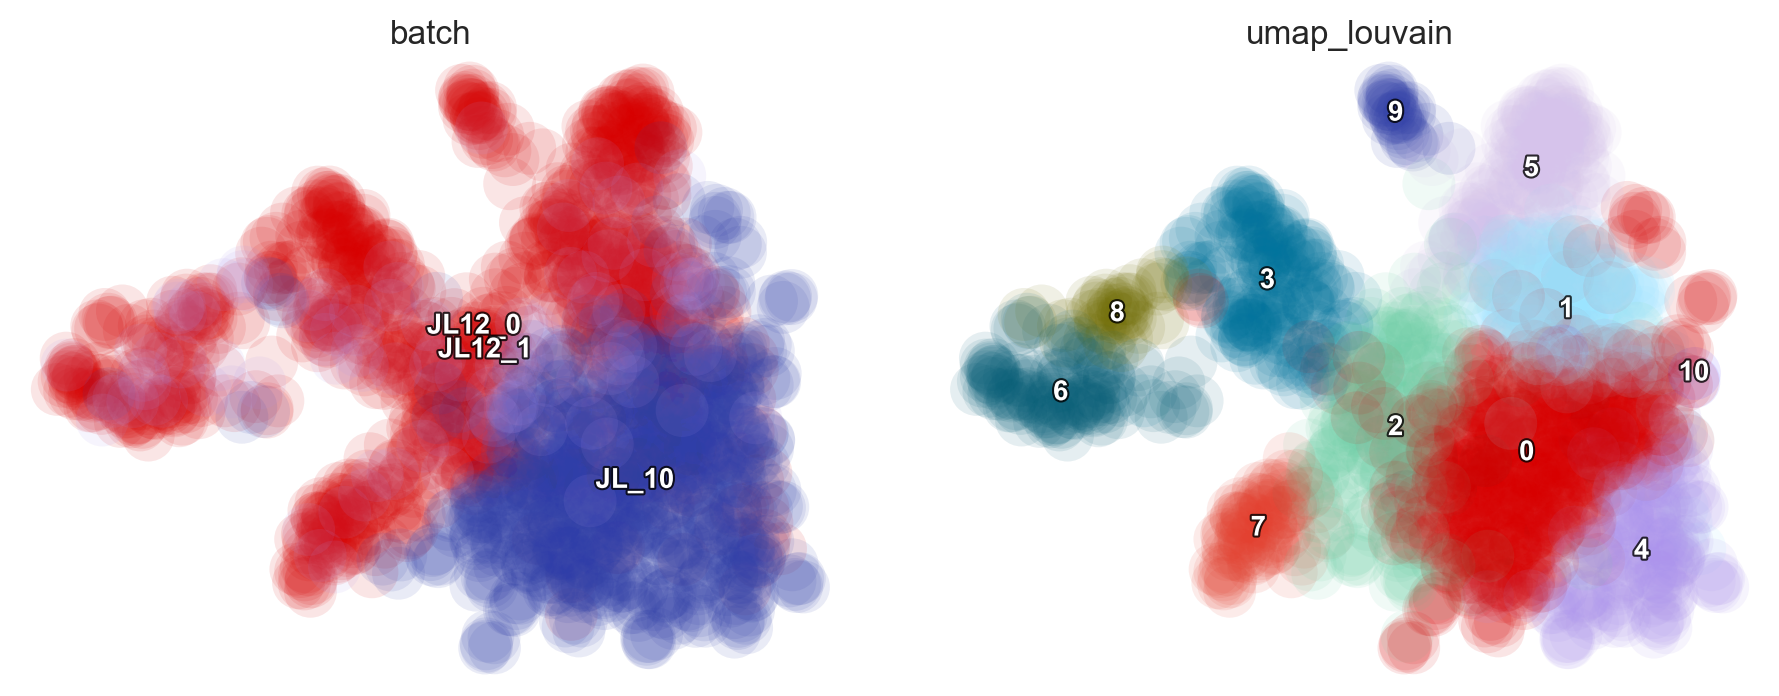

In [ ]:
dyn.tl.louvain(
    adata_labeling,
    obsm_key="X_umap",
    result_key="umap_louvain",
    resolution=0.7,
    adj_matrix=adata_labeling.obsp["X_pca_connectivities"],
)
dyn.pl.scatters(adata_labeling, color=["batch", "umap_louvain"])
